# Import and Read

In [79]:
# wide screen
from IPython.core.display import display, HTML
from IPython import get_ipython as get_ipython
display(HTML(
    '<style>'
        '#notebook { padding-top:0px !important;margin-left:-30px !important; } ' 
        '.container { width:100% !important; } '
        '.end_space { min-height:0px !important; } '
    '</style>'
))

In [145]:
import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [146]:
df = pd.read_csv('./data/clasdb_pi_plus_n.txt', delimiter='\t', header=None)
df.columns = ['Ebeam', 'W', 'Q2', 'cos_theta', 'phi', 'dsigma_dOmega', 'error', 'id']

In [147]:
df.loc[8314:65671, 'Ebeam'] = 5.754

In [148]:
df['phi'] = df.phi.apply(lambda x: math.radians(x))

# Preprocessing (remove soft dups)

In [149]:
df.head()

,Ebeam,W,Q2,cos_theta,phi,dsigma_dOmega,error,id
0,1.515,1.11,0.3,0.991445,0.261799,15.370,5.264366,E8M1
1,1.515,1.11,0.3,0.991445,0.785398,4.511,1.743136,E8M1
2,1.515,1.11,0.3,0.991445,1.308997,4.478,1.611260,E8M1
3,1.515,1.11,0.3,0.991445,1.832596,5.136,1.523529,E8M1
4,1.515,1.11,0.3,0.991445,2.356194,5.078,1.219442,E8M1


In [150]:
df[(df.Ebeam == 5.754)&
  (df.W == 1.27)&
  (df.Q2 == 2.05)&
  (df.cos_theta == 0.9)&
  (df.phi == 0.1308996938995747)]

,Ebeam,W,Q2,cos_theta,phi,dsigma_dOmega,error,id
15346,5.754,1.27,2.05,0.9,0.1309,1.72870,0.10616,E13M44
53610,5.754,1.27,2.05,0.9,0.1309,1.17904,0.07595,E14M35


need to fix it!

In [151]:
df = df.iloc[df[['Ebeam', 'W', 'Q2', 'cos_theta', 'phi']].drop_duplicates().index]

# XGB W == X

In [152]:
W = 1.23

In [153]:
df_se = df[df.W == W]

In [154]:
# Extract the features and target column
X = df[['Ebeam', 'W', 'Q2', 'cos_theta', 'phi']]
y = df['dsigma_dOmega']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Train the XGBoost model
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', 
                             n_estimators=10000, 
                             max_depth=100, 
                             learning_rate=0.01, 
                             n_jobs=-1 )
xgb_model.fit(X_train, y_train)

# Make predictions on the testing set and calculate the mean squared error
y_pred = xgb_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)

/Users/andrey.golda/.pyenv/versions/3.9.0/lib/python3.9/site-packages/xgboost/data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


Mean Squared Error: 0.18321562950461714


# Find fixed ['Ebeam', 'W', 'Q2', 'cos_theta'] max statistics for validatetion

In [155]:
max_stat_example = df_se.groupby(['Ebeam', 'W', 'Q2', 'cos_theta']).\
                    count().sort_values('id', ascending=False).reset_index().iloc[0].to_dict()

In [156]:
max_stat_example

{'Ebeam': 5.754,
 'W': 1.23,
 'Q2': 2.05,
 'cos_theta': -0.3,
 'phi': 24.0,
 'dsigma_dOmega': 24.0,
 'error': 24.0,
 'id': 24.0}

In [157]:
df_fix = df_se[(df_se.Ebeam == max_stat_example['Ebeam'])&
               (df_se.W == max_stat_example['W'])&
               (df_se.Q2 == max_stat_example['Q2'])&
               (df_se.cos_theta == max_stat_example['cos_theta'])]

In [158]:
df_fix = df_fix.sort_values('phi')

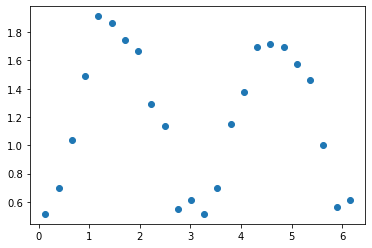

In [159]:
plt.scatter(x=df_fix.phi, 
            y=df_fix.dsigma_dOmega)

# Predict according to fixed ['Ebeam', 'W', 'Q2', 'cos_theta']

In [180]:
df_test_fixed = pd.DataFrame({'Ebeam' : [max_stat_example['Ebeam'] for _ in np.arange(0, 2*np.pi, 0.01)], 
                              'W' : [max_stat_example['W'] for _ in np.arange(0, 2*np.pi, 0.01)], 
                              'Q2' : [max_stat_example['Q2'] for _ in np.arange(0, 2*np.pi, 0.01)], 
                              'cos_theta' : [max_stat_example['cos_theta'] for _ in np.arange(0, 2*np.pi, 0.01)],
                              'phi' : [phi for phi in np.arange(0, 2*np.pi, 0.01)]})

In [181]:
dsigma_dOmega_predicted = xgb_model.predict(df_test_fixed)

# Fit a + b * cos(2*phi) + c * cos(phi) 

In [182]:
#importing necessary libraries 
import numpy as np
from scipy.optimize import curve_fit
 
#define the function 
def func(x, a, b, c): 
    return a + b*np.cos(2*x) + c*np.cos(x) 

 
#input data 
xdata = df_fix.phi
ydata = df_fix.dsigma_dOmega 
 
#fitting the data 
popt, pcov = curve_fit(func, xdata, ydata, p0= [0, 1, 2]) 
 
a, b, c = popt[0], popt[1], popt[2]
#print the fitted parameters 
print("a = %s , b = %s, c = %s" % (a, b, c))

a = 1.1906108279556251 , b = -0.6674207720293355, c = 0.004094634645273043


In [183]:
phi_theory = [i for i in np.arange(0, 2*np.pi, 0.01)]
dsigma_dOmega_theory = [func(x, a, b, c) for x in phi_theory]

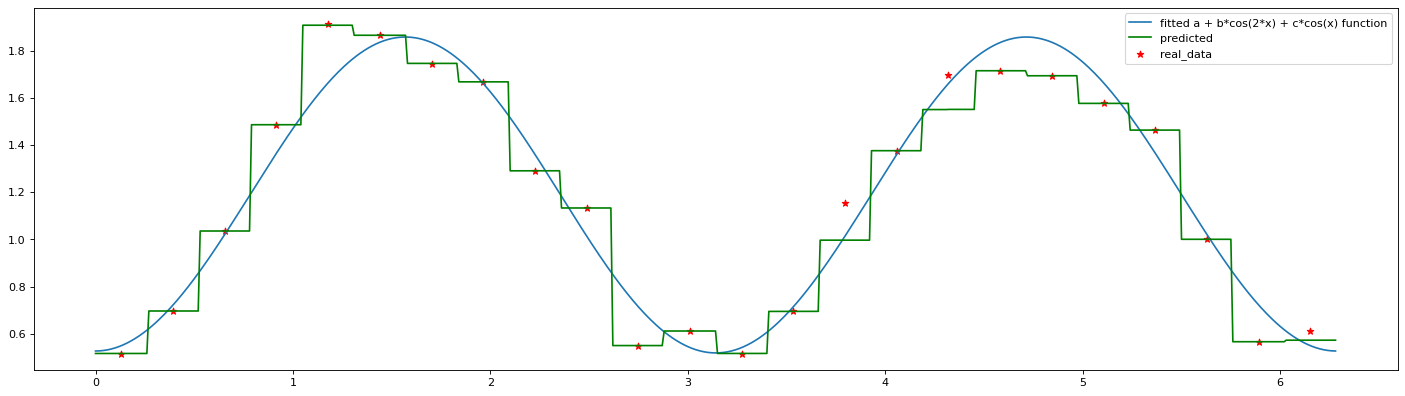

In [184]:
plt.figure(figsize=(22, 6), dpi=80)
plt.plot(phi_theory, 
         dsigma_dOmega_theory, 
         label=f'fitted a + b*cos(2*x) + c*cos(x) function')
plt.plot(phi_theory, 
         dsigma_dOmega_predicted, 
         color='green', label=f'predicted')
plt.scatter(x=df_fix.phi, 
            y=df_fix.dsigma_dOmega, 
            color='red', marker='*', label='real_data')
plt.legend()

# Interpolate

In [185]:
from scipy import interpolate

def f_interpol(x):
    x_points = df_fix.phi.to_numpy()
    y_points = df_fix.dsigma_dOmega.to_numpy()

    tck = interpolate.splrep(x_points, y_points)
    return interpolate.splev(x, tck)

print(f_interpol(12))

982.5141389351791


In [186]:
dsigma_dOmega_interpolated = [float(f_interpol(phi)) for phi in phi_theory]

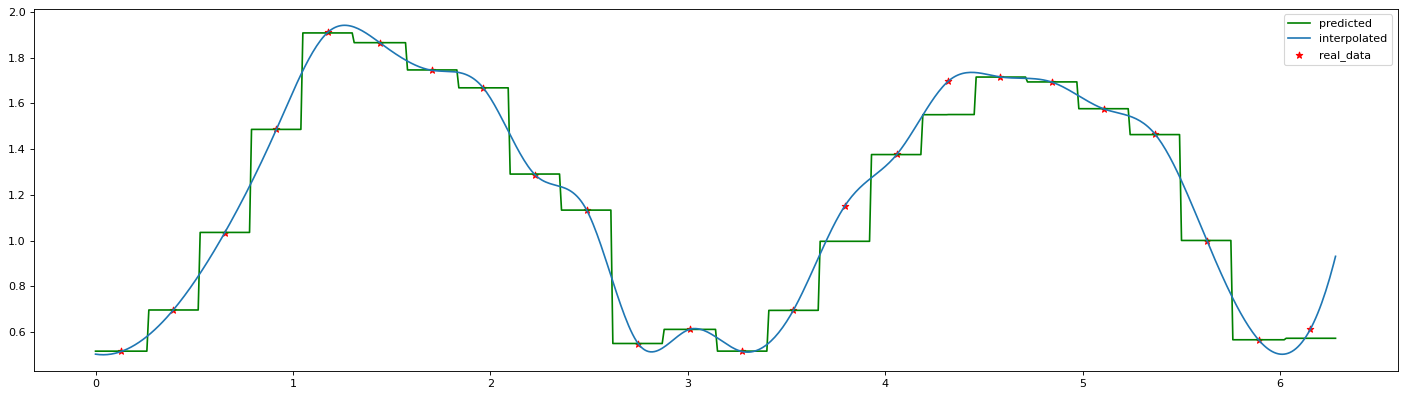

In [187]:
plt.figure(figsize=(22, 6), dpi=80)
plt.scatter(x=df_fix.phi, 
            y=df_fix.dsigma_dOmega,
            color='red', marker='*', label='real_data')
plt.plot(phi_theory, 
         dsigma_dOmega_predicted, 
         color='green', label=f'predicted')
plt.plot(phi_theory, 
         dsigma_dOmega_interpolated,
         label=f'interpolated')
plt.legend()